In [9]:
from ismn_simple_processor import process_ismn_simple


In [15]:
# Process your ISMN data
zip_file = r"data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip"
gdf = process_ismn_simple(zip_file, r"data\stations", "africa.shp")


Processing data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip directly...
Found 199 sensor files in zip
Processing file 1/199
Processing file 101/199
Successfully processed 199 sensors

Shapefile created: data\stations\africa.shp
Total sensors: 199
Networks: 3
Stations: 41
CSV saved: data\stations\africa.csv

ISMN DATA PROCESSING SUMMARY
Total Sensors: 199
Total Stations: 41
Total Networks: 3

Coordinate Range:
Latitude: -2.8828 to 13.6456
Longitude: -3.9351 to 40.0298

Top Networks by Sensor Count:
  TAHMO: 173 sensors
  AMMA-CATCH: 23 sensors
  SD DEM: 3 sensors


                                           Sensor_ID       Station_ID  \
0            SD-DEM_SD-DEM_Demokeya_static_variables         Demokeya   
1  SD-DEM_SD-DEM_Demokeya_sm_0.050000_0.050000_CS...         Demokeya   
2  SD-DEM_SD-DEM_Demokeya_sm_0.100000_0.100000_HY...         Demokeya   
3  AMMA-CATCH_AMMA-CATCH_Belefoungou-Top_static_v...  Belefoungou-Top   
4  AMMA-CATCH_AMMA-CATCH_Belefoungou-Top_sm_0.050...  Belefoungou-Top   

   Network_ID Network_Name  Latitude  Longitude  \
0      SD DEM       SD DEM   3.00000   -3.00000   
1      SD DEM       SD DEM  13.28290   30.47830   
2      SD DEM       SD DEM  13.28290   30.47830   
3  AMMA-CATCH   AMMA-CATCH   3.00000   -3.00000   
4  AMMA-CATCH   AMMA-CATCH   9.78986    1.70994   

                                           File_Path  \
0  SD_DEM/Demokeya/SD-DEM_SD-DEM_Demokeya_static_...   
1  SD_DEM/Demokeya/SD-DEM_SD-DEM_Demokeya_sm_0.05...   
2  SD_DEM/Demokeya/SD-DEM_SD-DEM_Demokeya_sm_0.10...   
3  AMMA-CATCH/Belefoungou-Top/

<Axes: >

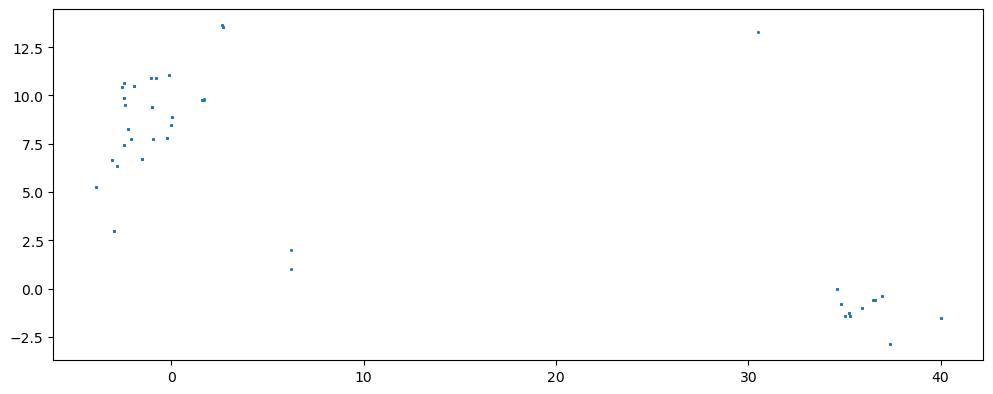

In [16]:
# Display the results
print(gdf.head())
gdf.plot(figsize=(12, 8), markersize=1)

The above code creates vertical lines at a specific long values- this might be a bug. vertical lines are a clear indicator of coordinate parsing issues, not CRS problems. The pattern shows that longitude values are being incorrectly parsed or defaulting to certain values, creating those artificial vertical alignments.
Below is the refined code

In [17]:
from ismn_improved_processor import process_ismn_improved

# Process with improved coordinate extraction
zip_file = r"data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip"
gdf = process_ismn_improved(zip_file, "data\stations", "africa_2.shp")


Processing data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip directly...
Found 199 sensor files in zip
Processing file 1/199
Processing file 101/199
Successfully processed 158 sensors

COORDINATE ANALYSIS

Coordinate extraction sources:
   ismn_metadata: 158 sensors

Geographic distribution:
   Latitude range: -2.8828 to 13.6456
   Longitude range: -3.9351 to 40.0298
Applying quality filters...
Filtered 0 problematic records

Shapefile created: data\stations\africa_2.shp
Total sensors: 158
Networks: 3
Stations: 41
CSV saved: data\stations\africa_2.csv


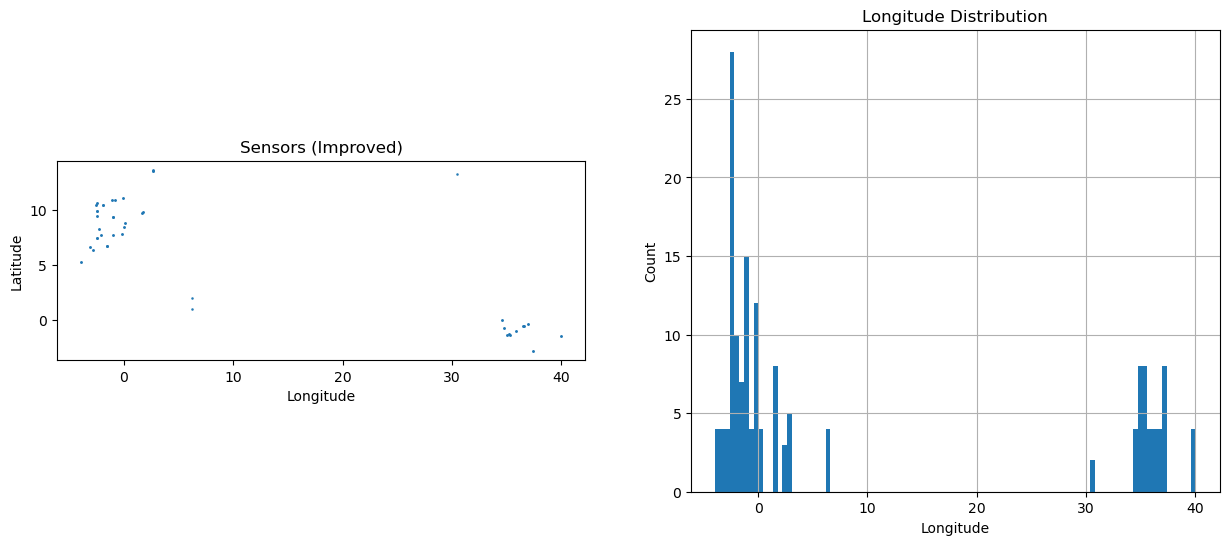

In [18]:

# Visualize to check for improvements
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sensors
gdf.plot(ax=ax1, markersize=0.5, alpha=0.7)
ax1.set_title("Sensors (Improved)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Check longitude distribution (should be more spread out now)
gdf['Longitude'].hist(bins=100, ax=ax2)
ax2.set_title("Longitude Distribution")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Count")
plt.show()

In [ ]:
## ISMN Data Processing to Generate Point Shapefile with Daily Soil Moisture Statistics (Single ZIP File)

### Step 1: Import Required Libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from ismn.interface import ISMN_Interface

### Step 2: Define Paths
zip_file_path = r'data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip'  # Update path
output_shapefile = r'data\stations\data.shp'

### Step 3: Initialize ISMN Interface
ds = ISMN_Interface(zip_file_path, parallel=True)

### Step 4: Process Networks, Stations, and Sensors
all_data = []

for network in ds.networks:
    for station in ds[network]:
        for sensor_index in range(len(ds[network][station])):
            sensor = ds[network][station][sensor_index]

            sensor_id = sensor.metadata['instrument']['val']  # Sensor ID from metadata
            lat = sensor.metadata['latitude']['val']
            lon = sensor.metadata['longitude']['val']
            station_id = sensor.metadata['station']['val']
            network_name = sensor.metadata['network']['val']

            variable = sensor.metadata['variable']['val']
            if variable.lower() != 'soil moisture':
                continue

            ts = sensor.data
            if ts is None or ts.empty:
                continue

            ts = ts.rename(columns={'soil_moisture': 'soil moisture'})  # Ensure consistent naming
            ts['date'] = ts.index.date

            # Calculate daily statistics
            daily_stats = ts.groupby('date')['soil moisture'].agg([
                ('mean', np.nanmean),
                ('max', np.nanmax),
                ('min', np.nanmin),
                ('std', np.nanstd)
            ]).reset_index()

            daily_stats['sensor_id'] = sensor_id
            daily_stats['station_id'] = station_id
            daily_stats['network_name'] = network_name
            daily_stats['latitude'] = lat
            daily_stats['longitude'] = lon

            # Static variables to retain
            static_vars = {
                'clay_fraction': sensor.metadata.get('clay_fraction', {}).get('val', np.nan),
                'climate_KG': sensor.metadata.get('climate_KG', {}).get('val', 'Unknown'),
                'climate_insitu': sensor.metadata.get('climate_insitu', {}).get('val', 'Unknown'),
                'elevation': sensor.metadata.get('elevation', {}).get('val', np.nan),
                'instrument': sensor.metadata.get('instrument', {}).get('val', 'Unknown'),
                'lc_2000': sensor.metadata.get('lc_2000', {}).get('val', 'Unknown'),
                'lc_2005': sensor.metadata.get('lc_2005', {}).get('val', 'Unknown'),
                'lc_2010': sensor.metadata.get('lc_2010', {}).get('val', 'Unknown'),
                'lc_insitu': sensor.metadata.get('lc_insitu', {}).get('val', 'Unknown'),
                'organic_carbon': sensor.metadata.get('organic_carbon', {}).get('val', np.nan),
                'sand_fraction': sensor.metadata.get('sand_fraction', {}).get('val', np.nan),
                'saturation': sensor.metadata.get('saturation', {}).get('val', np.nan),
                'silt_fraction': sensor.metadata.get('silt_fraction', {}).get('val', np.nan),
                'timerange_from': sensor.metadata.get('timerange_from', {}).get('val', 'Unknown'),
                'timerange_to': sensor.metadata.get('timerange_to', {}).get('val', 'Unknown'),
                'variable': variable
            }

            for key, value in static_vars.items():
                daily_stats[key] = value

            all_data.append(daily_stats)

### Step 5: Combine All Sensor Data
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)

    ### Step 6: Prepare Geospatial Data
    geometry = [Point(xy) for xy in zip(final_df['longitude'], final_df['latitude'])]
    gdf = gpd.GeoDataFrame(final_df, geometry=geometry, crs='EPSG:4326')

    ### Step 7: Export to Shapefile
    gdf.to_file(output_shapefile)
    print(f"Shapefile successfully written to {output_shapefile}")
else:
    print("No soil moisture data found in the provided ZIP file.")


INFO - 2025-06-14 16:49:23,135: Collecting metadata with 8 processes.
2025-06-14 16:49:23,135 - INFO - Collecting metadata with 8 processes.


This may take a few minutes, but is only done once...



Stations Processed:   0%|          | 0/41 [00:00<?, ?it/s]INFO - 2025-06-14 16:49:23,854: insitu land cover classification available: SD_DEM/Demokeya/SD-DEM_SD-DEM_Demokeya_static_variables.csv
2025-06-14 16:49:23,854 - INFO - insitu land cover classification available: SD_DEM/Demokeya/SD-DEM_SD-DEM_Demokeya_static_variables.csv
2025-06-14 16:49:23,922 - INFO - Processed file AMMA-CATCH/Belefoungou-Top/AMMA-CATCH_AMMA-CATCH_Belefoungou-Top_sm_0.050000_0.050000_CS616_20160614_20250614.stm
2025-06-14 16:49:23,928 - INFO - Processed file AMMA-CATCH/Belefoungou-Mid/AMMA-CATCH_AMMA-CATCH_Belefoungou-Mid_sm_0.050000_0.050000_CS616_20160614_20250614.stm
2025-06-14 16:49:23,934 - INFO - Processed file AMMA-CATCH/Nalohou-Top/AMMA-CATCH_AMMA-CATCH_Nalohou-Top_sm_0.050000_0.050000_CS616_20160614_20250614.stm
2025-06-14 16:49:23,938 - INFO - Processed file AMMA-CATCH/Banizoumbou/AMMA-CATCH_AMMA-CATCH_Banizoumbou_sm_0.050000_0.050000_CS616-1_20160614_20250614.stm
2025-06-14 16:49:23,939 - INFO - Pr

Metadata collection finished after 3 Seconds.
Metadata for this archive and Logfile stored in data\africa\python_metadata
Using the existing ismn metadata in data\africa\python_metadata\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.csv to set up ISMN_Interface. 
If there are issues with the data reader, you can remove the metadata csv file to repeat metadata collection.


KeyError: Station 'Banizoumbou' with Sensors: ['CS616-1_soil_moisture_0.050000_0.050000', 'CS616-2_soil_moisture_0.050000_0.050000']

In [27]:
## ISMN Data Processing to Generate Point Shapefile with Daily Soil Moisture Statistics (Single ZIP File)

### Step 1: Import Required Libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from ismn.interface import ISMN_Interface

### Step 2: Define Paths
zip_file_path = r'data\africa\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.zip'  # Update path
output_shapefile = r'data\stations\data.shp'


### Step 3: Initialize ISMN Interface
reader = ISMN_Interface(zip_file_path, parallel=True)

### Step 4: Process Networks, Stations, and Sensors
all_data = []

for network in reader.networks:
    for station in reader[network].stations:
        for sensor in station.sensors:
            if sensor.variable.lower() != 'soil moisture':
                continue

            ts = station.read_variable(sensor=sensor, return_raw_values=False)
            if ts is None or ts.empty:
                continue

            ts['date'] = ts.index.date

            # Calculate daily statistics
            daily_stats = ts.groupby('date')['soil moisture'].agg([
                ('mean', np.nanmean),
                ('max', np.nanmax),
                ('min', np.nanmin),
                ('std', np.nanstd)
            ]).reset_index()

            metadata = sensor.metadata.to_pd().set_index('key')['val'].to_dict()

            lat = metadata.get('latitude', np.nan)
            lon = metadata.get('longitude', np.nan)
            station_id = metadata.get('station', 'Unknown')
            network_name = metadata.get('network', 'Unknown')

            daily_stats['sensor_id'] = sensor.instrument
            daily_stats['station_id'] = station_id
            daily_stats['network_name'] = network_name
            daily_stats['latitude'] = lat
            daily_stats['longitude'] = lon

            # Static variables to retain
            static_vars = [
                'clay_fraction', 'climate_KG', 'climate_insitu', 'elevation', 'instrument',
                'lc_2000', 'lc_2005', 'lc_2010', 'lc_insitu', 'organic_carbon',
                'sand_fraction', 'saturation', 'silt_fraction', 'timerange_from', 'timerange_to', 'variable'
            ]

            for var in static_vars:
                daily_stats[var] = metadata.get(var, np.nan)

            all_data.append(daily_stats)

### Step 5: Combine All Sensor Data
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)

    ### Step 6: Prepare Geospatial Data
    geometry = [Point(xy) for xy in zip(final_df['longitude'], final_df['latitude'])]
    gdf = gpd.GeoDataFrame(final_df, geometry=geometry, crs='EPSG:4326')

    ### Step 7: Export to Shapefile
    gdf.to_file(output_shapefile)
    print(f"Shapefile successfully written to {output_shapefile}")
else:
    print("No soil moisture data found in the provided ZIP file.")


Using the existing ismn metadata in data\africa\python_metadata\Data_separate_files_header_20160614_20250614_11438_iyLN_20250614.csv to set up ISMN_Interface. 
If there are issues with the data reader, you can remove the metadata csv file to repeat metadata collection.


AttributeError: 'str' object has no attribute 'sensors'